In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 24
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(5), cmap(1), cmap(3), cmap(6), cmap(7), cmap(0), cmap(2)]
cmap_subset = ListedColormap(subset_colors)

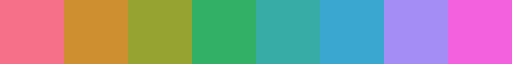

In [5]:
cmap

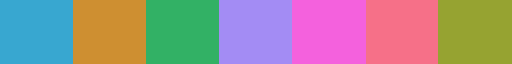

In [6]:
cmap_subset

### Coverage-Cost Experiments

In [41]:
# Load experiment results
dataset = 'anuran'
fname = "../data/experiments/" + dataset + "/relative_coverage/exp_test.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2, 3], index_col=0)

In [42]:
# Compute statistics:
grouped = experiment_df.T.groupby(level = [0,1,2])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [43]:
table_df = mean_df.iloc[-4,:].to_frame()
table_df.loc['normalized-clustering-cost',:]

7
Forest-Depth-2   Forest-Depth-2    8.037594
                 IMM               7.885014
                 KMeans            6.612702
Forest-Depth-3   Forest-Depth-3    6.979122
                 IMM               7.390360
                 KMeans            6.203617
Forest-Depth-4   Forest-Depth-4    6.458682
                 IMM               7.242630
                 KMeans            6.068668
Forest-Depth-IMM Forest-Depth-IMM  6.211147
                 IMM               7.137848
                 KMeans            5.968444
IMM              IMM               8.731855
IMM-outliers     IMM               6.707030
                 IMM-outliers      6.940245
                 KMeans            5.351350
KMeans           KMeans            7.251671

In [31]:
# While we're at it, take a look at explanation tree results:
fname = "../data/experiments/" + dataset + "/explanation_tree.csv"
explanation_tree_df = pd.read_csv(fname, index_col=0)

In [32]:
explanation_tree_df

,normalized-clustering-cost,overlap,coverage,max-rule-legnth,weighted-average-rule-length
0,6.26999,1.0,0.85893,6,5.307929


### Plotting

In [44]:
#colormap = no_oblique_cmap_subset
#module_list = [m for m in mean_df['normalized-clustering-cost'].columns if m not in baseline_list]
#module_list = [m for m in mean_df['normalized-clustering-cost'][model].columns]

colormap = cmap_subset
baseline_list = ['KMeans-Full', 'IMM-Full']
module_list = ['KMeans', 'IMM', 'Forest-Depth-2', 
               'Forest-Depth-3','Forest-Depth-4', 'Forest-Depth-IMM','IMM-outliers']
color_dict = {mod : i for i,mod in enumerate(module_list)}

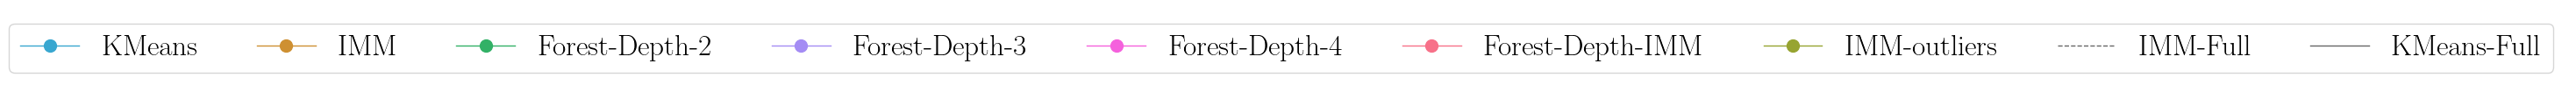

In [ ]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = 'dashed',
        label="IMM-Full",
        alpha=0.6
    )
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = '-',
        label="KMeans-Full",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=len(module_list) + len(baseline_list))
ax.axis('off')
#plt.savefig('../figures/relative_coverage/legend.png', bbox_inches = 'tight', dpi = 300)

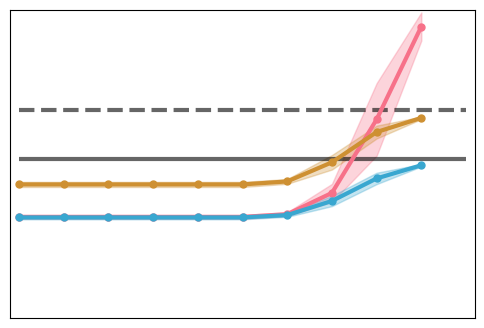

In [48]:
model = 'Forest-Depth-IMM'
measure = 'normalized-clustering-cost'
#measure = 'silhouette'
xlabel = 'minimum coverage'
ylabel = measure if measure != 'normalized-clustering-cost' else 'cost'
#fname = '../figures/relative_coverage/' + ylabel + '/' + dataset + '/' + model + '.png'
fname = None

xaxis = False
yaxis = False
if not xaxis:
    xlabel = ''
if not yaxis:
    ylabel = ''

plot_colors = [colormap(color_dict[mod]) for mod in mean_df[measure][model].columns]
plot_cmap = ListedColormap(plot_colors)
measure_df = mean_df[measure]

# Measurements
if measure == 'normalized-clustering-cost':
    norm = mean_df[measure]['KMeans']['KMeans'].iloc[0]
else:
    norm = 1

measure_df = mean_df[measure] / norm

plot_df = mean_df[measure][model]
plot_df['KMeans-Full'] = mean_df[measure]['KMeans']
plot_df['IMM-Full'] = mean_df[measure]['IMM']
plot_df /= norm

plot_std_df = std_df[measure][model]
plot_std_df['KMeans-Full'] = std_df[measure]['KMeans']
plot_std_df['IMM-Full'] = std_df[measure]['IMM']
plot_std_df /= norm

# Domain:
#domain_df = mean_df['coverage'][model]
domain_array = np.array([list(np.linspace(0.5,1,11))] * len(plot_df.columns)).T
domain_df = pd.DataFrame(domain_array, columns = plot_df.columns)

xlim = (0.49, 1.01)
ylim = (measure_df.min().min() - 0.05, measure_df.max().max() + 0.05)
experiment_plotter(
    plot_df,
    plot_std_df,
    domain_df,
    xlabel = xlabel,
    ylabel = ylabel,
    cmap = plot_cmap,
    baseline_list = ['KMeans-Full', 'IMM-Full'],
    legend = False,
    xlim = xlim,
    ylim = ylim,
    xaxis = xaxis,
    yaxis = yaxis,
    filename = fname,
)

In [45]:
measure_df.iloc[:-1,:].min().min()

0.5994177894081568

In [43]:
measure_df.iloc[:-1,:]

Forest-Depth-2                     Forest-Depth-4                      \
  Forest-Depth-2       IMM    KMeans Forest-Depth-4       IMM    KMeans   
0       0.913199  0.952760  0.907564       0.954897  0.997778  0.953366   
1       0.913199  0.952760  0.907564       0.954897  0.997778  0.953366   
2       0.913144  0.952588  0.907400       0.954897  0.997778  0.953366   
3       0.933855  0.966643  0.922464       0.954897  0.997778  0.953366   
4       0.941768  0.963070  0.924924       0.954897  0.997778  0.953366   
5       0.943795  0.963618  0.925460       0.955541  0.998474  0.953913   
6       0.947010  0.967484  0.927893       0.968245  1.011611  0.962904   
7       0.984088  1.003861  0.955180       0.983210  1.023799  0.972347   
8       1.025808  1.029643  0.975669       1.007274  1.040509  0.987615   
9       1.050404  1.040421  0.986173       1.027951  1.045777  0.991564   

  Forest-Depth-6                     Forest-Depth-IMM                      \
  Forest-Depth-6       IMM    KMeans Forest-Depth-IMM       IMM    KMeans   
0       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
1       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
2       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
3       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
4       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
5       0.959099  1.003779  0.958307         0.957047  1.001056  0.955973   
6       0.961706  1.006859  0.960309         0.962697  1.007255  0.960106   
7       0.982240  1.027696  0.976614         0.982616  1.026062  0.975459   
8       1.004813  1.042282  0.989587         1.005673  1.041641  0.989201   
9       1.029742  1.046504  0.992240         1.028840  1.046183  0.991742   

        IMM IMM-outliers                        KMeans  
        IMM          IMM IMM-outliers    KMeans KMeans  
0  1.054999     0.611483     0.599418  0.599418    1.0  
1  1.054999     0.656202     0.633585  0.633585    1.0  
2  1.054999     0.727449     0.691412  0.681718    1.0  
3  1.054999     0.776510     0.753359  0.715553    1.0  
4  1.054999     0.854952     0.834616  0.801146    1.0  
5  1.054999     0.886185     0.879428  0.830791    1.0  
6  1.054999     0.924107     0.914725  0.859588    1.0  
7  1.054999     0.974387     0.962357  0.910514    1.0  
8  1.054999     1.006210     0.997370  0.942473    1.0  
9  1.054999     1.029497     1.029497  0.969937    1.0

In [5]:
# Load experiment results
dataset = 'climate'
fname = "../data/experiments/" + dataset + "/explanation_tree.csv"
explanation_tree_df = pd.read_csv(fname, index_col=0)

In [6]:
explanation_tree_df

,normalized-clustering-cost,overlap,coverage,max-rule-legnth,weighted-average-rule-length
0,11.485357,1.0,0.898256,5,3.576052
